In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LINA
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
import os
import sys
import pandas as pd
from collections import OrderedDict
%matplotlib inline

plt.rc("figure", facecolor="white")

params = {
    'lines.markersize' : 10,
    'axes.labelsize': 20,
    'font.size': 20,
    'legend.fontsize': 20,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'text.usetex': False,
   }
plt.rcParams.update(params)
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]   

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)   

#grab our checkName code
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import salty

# Scikit Learn

In [2]:
datadf = pd.DataFrame.from_csv('../salty/data/salts_with_descriptors.csv')
datadf = datadf.reset_index(drop=False)#.sample(frac=1)
atadf = datadf.loc[:, (datadf != 0).any(axis=0)] #remove columns where all values are 0
datadf.dropna(inplace=True) #remove empty columns and rows with NaN 

datadf = datadf.sample(frac=1).reset_index(drop=True)
anilist = datadf['NAME_ANI']
catlist = datadf['NAME_CAT']
datadf = datadf.drop('NAME_CAT',1) #remove non-numeric columns and normalize values
datadf = datadf.drop('NAME_ANI',1)
datadf = datadf.drop("salt_name",1)

data=np.array(datadf)
n = data.shape[0]
d = data.shape[1]
d -= 1
n_train = int(n*0.8)
n_test  = n - n_train
data = np.random.permutation(data)

X_train = np.zeros((n_train,d))
X_test  = np.zeros((n_test,d))
Y_train = np.zeros((n_train))
Y_test = np.zeros((n_test))

X_train[:] = data[:n_train,:-1]
Y_train[:] = np.log(data[:n_train,-1])

X_test[:] = data[n_train:,:-1]
Y_test[:] = np.log(data[n_train:,-1])

print(X_train.shape)
print(X_test.shape)

(2927, 190)
(732, 190)


In [5]:
model = Lasso(alpha=1.5e-2,tol=1e-10, max_iter=4000)
model.fit(X_train,Y_train)

Lasso(alpha=0.015, copy_X=True, fit_intercept=True, max_iter=4000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=1e-10, warm_start=False)

In [6]:
f = open('../salty/data/Deslist','r')
deslist = []
for line in f:
    deslist.append(line.strip('\n\t'))
cols_cat = [s + "-cation" for s in deslist]
cols_ani = [s + "-anion" for s in deslist]
deslist = cols_cat + cols_ani + ["Temperature_K" , "Pressure_kPa", "Density_kg/m"]

i=0
for a in range(len(deslist)-3):
    if model.coef_[a] != 0:
        print(a, deslist[a])
        i+=1
print(i)

(97, 'BertzCT-anion')
(98, 'Ipc-anion')
(102, 'Kappa3-anion')
(117, 'MolWt-anion')
(128, 'TPSA-anion')
(184, 'VSA_EState8-anion')
(185, 'VSA_EState9-anion')
7


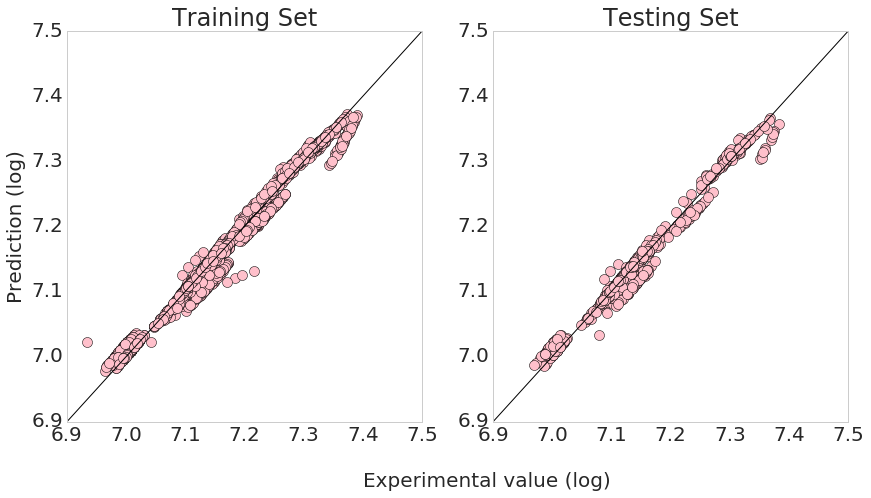

In [12]:
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(14,7), dpi=300)
    ax = fig.add_subplot(121)
    ax.plot(Y_train,model.predict(X_train),"o",color = "pink")
    ax.plot(np.arange(6.75,7.75,0.0001),np.arange(6.75,7.75,0.0001),color = 'black')
    ax.axis([6.9,7.5,6.9,7.5])
#     plt.xlim(-6,-1)
#     plt.ylim(-6,-1)
    plt.text(7.4,6.8,'Experimental value (log)')
    plt.ylabel('Prediction (log)')
    plt.title('Training Set')
    plt.grid(False)
    ax2 = fig.add_subplot(122)
    ax2.plot(Y_test,model.predict(X_test),"o",color = "pink")
    ax2.plot(np.arange(6.75,7.75,0.0001),np.arange(6.75,7.75,0.0001),color = 'black')
    ax2.axis([6.9,7.5,6.9,7.5])
#     plt.xlim(-6,-1)
#     plt.ylim(-6,-1)
    plt.title('Testing Set')
    plt.grid(False)
fig.savefig(filename='../webapp/salty_web_app/collection/static/images/lasso_regression.png', bbox_inches='tight', format='png')    

In [18]:
datadf["Temperature_K"][1]

353.14999999999998

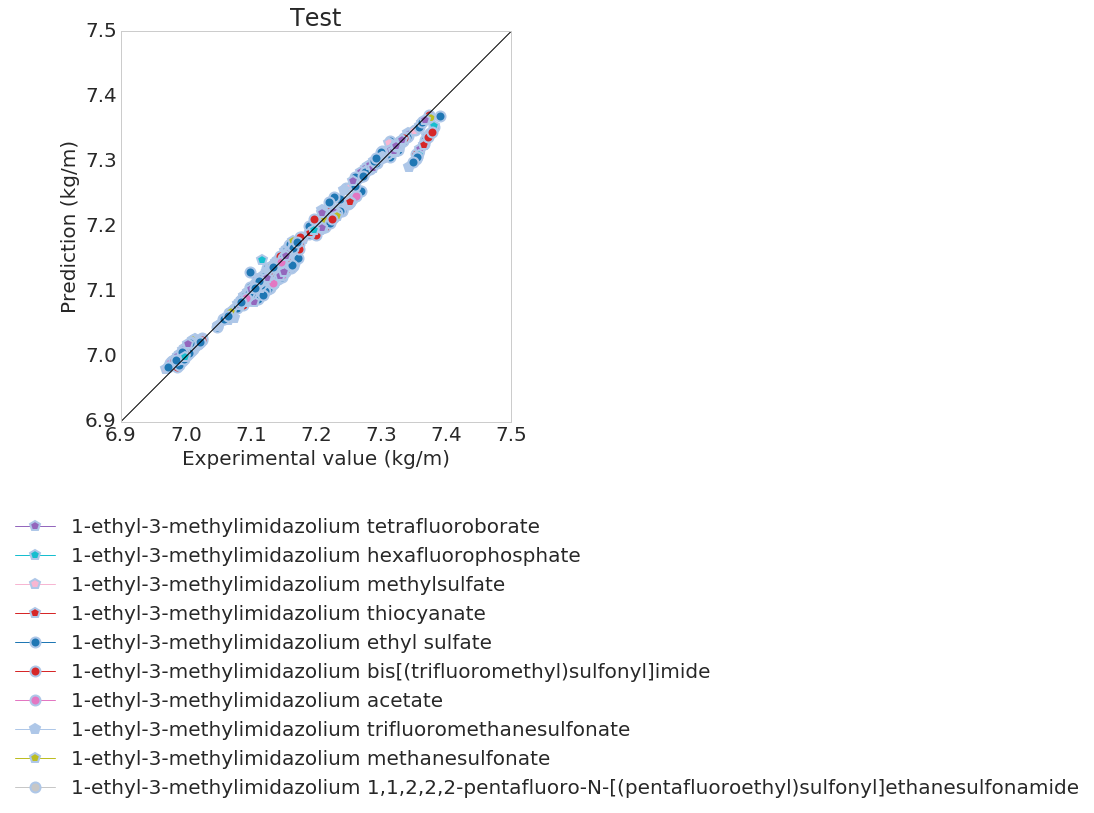

In [19]:
###LOAD VIS WITH TOOLTIPS
import sys
reload(sys)
sys.setdefaultencoding("utf-8")
labels=[]
T=[]
P=[]
colors=[]
shapes=[]
edge_colors=[]
check=[]
scatter=[]
with plt.style.context('seaborn-whitegrid'):
    fig=plt.figure(figsize=(7,7), dpi=300)
    plt.xlabel('Experimental value (kg/m)')
    plt.ylabel('Prediction (kg/m)')
    plt.title('Train')
    plt.grid(False)
    
    ax2 = fig.add_subplot(111)
    for i in range(len(X_test)):
        catIndex = salty.checkName(catlist[i+n_train],index=True)[1]
        aniIndex = salty.checkName(anilist[i+n_train],index=True)[1]
        name = str("%s %s" % (catlist[i+n_train], anilist[i+n_train]))
        labels.append(name)
        T.append(datadf["Temperature_K"][i+n_train])
        P.append(datadf["Pressure_kPa"][i+n_train])
        
        colors.append(tableau20[aniIndex%20])
        edge_colors.append(tableau20[catIndex%20])
        check.append([catIndex,aniIndex])
        
        if catIndex >= 20 and aniIndex >= 20:
            shapes.append("s")
        elif catIndex < 20 and aniIndex >= 20:
            shapes.append("o")
        elif catIndex >= 20 and aniIndex < 20:
            shapes.append("8")
        elif catIndex < 20 and aniIndex < 20:
            shapes.append("p")
        
    scatter_this = ax2        
    for i in range(len(X_test)):
        ax2.plot(Y_test[i],model.predict(X_test[i].reshape(1,-1)),marker=shapes[i],color = colors[i],\
                    markeredgecolor = edge_colors[i], mew='2', label=labels[i])

        
    ax2.plot(np.arange(6.75,7.75,0.0001),np.arange(6.75,7.75,0.0001),color = 'black')
    ax2.axis([6.9,7.5,6.9,7.5])
    plt.title('Test')
    plt.grid(False)
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(2.5,-0.2))
    plt.show()

In [20]:
["Temperature_K" , "Pressure_kPa", "Density_kg/m"]
X=Y_test
Y=model.predict(X_test)
to_save=pd.DataFrame(np.transpose([X,Y,labels,T,P]),columns=["Density_kg/m, Experimental",\
        "Density_kg/m, Prediction", "Salt Name", "Temperature_K" , "Pressure_kPa"])

In [23]:
pd.DataFrame.to_csv(to_save, path_or_buf='../salty/data/data_2_d3_Press_Temp.csv', index=False)